# Решение задач классификации.

* Научимся решать задачи классификации с помощью различных моделей.
* Разберём, как подбирать гиперпараметры моделей по сетке.
* Научимся использовать пайплайны.
* Применим калибровку вероятностей.

## Задача 1. Многоклассовая классификация цветков ириса.

![Ирисы](irises.jpg)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data
y = iris.target

X.shape, y.shape

((150, 4), (150,))

Выведите на экран все различные значения целевой переменной, а также распределение классов

In [3]:
#your code here
set(y)

{0, 1, 2}

In [4]:
from collections import Counter

Counter(y)

Counter({0: 50, 1: 50, 2: 50})

Для решения этой задачи будем использовать **линейную модель - логистическую регрессию**.

Для начала разобъем данные на train и test (test - 20% от всех данных).

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, \
                                               random_state=1)

Обучим логистическую регрессию на train и выведем качество (accuracy) на train и на test.

In [6]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(Xtrain, ytrain)

# model.predict(Xtest) # классы
# model.predict_proba(Xtest) # вероятности классов

pred_train = model.predict(Xtrain)
pred_test = model.predict(Xtest)

#your code here
accuracy_score(ytrain,pred_train), accuracy_score(ytest,pred_test)

(0.9833333333333333, 0.9666666666666667)

Посмотрим на качество алгоритма на кросс-валидации.

In [7]:
from sklearn.model_selection import cross_val_score

#your code here
cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

0.9733333333333334

Получили очень высокую точность модели.

Посмотрим, можно ли улучшить качество модели **подбором её гиперпараметров**. Логистическая регрессия имеет гиперпараметр C - подберём его.

* Подбор гиперпараметров традиционно осуществляется "по сетке" с помощью функции ***GridSearchCV***. 

GridSearchCV - это класс, который ищет с помощью кросс-валидации (CV) по сетке наилучшую комбинацию искомых параметров. 

In [8]:
from sklearn.model_selection import GridSearchCV

params = {'C': np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(model, params)

grid.fit(X, y)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.9733333333333334
best params: {'C': 0.6}


Задача уже решена очень хорошо. На этом можно ставить точку.

Посмотрим на значения метрик.

In [9]:
from sklearn.metrics import classification_report

print(classification_report(ytest,pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.92      0.96        13
           2       0.86      1.00      0.92         6

   micro avg       0.97      0.97      0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



## Задача 2: задача XOR.

![How it works](XOR.png)

Создадим данные для задачи XOR

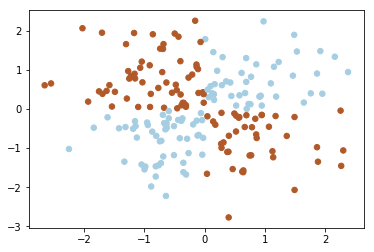

In [10]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Будем использовать функцию, которая рисует разделяющую границу, проведенную классификатором.

In [11]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

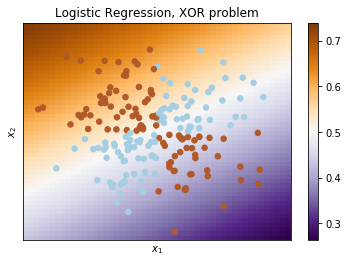

In [12]:
plot_boundary(LogisticRegression(solver='lbfgs'), X, y, "Logistic Regression, XOR problem")

Оценим качество полученной классификации.

In [13]:
cross_val_score(model, X, y, cv=3, scoring='accuracy').mean()

0.4997738579828132

Мы видим, что задача решена плохо. Попробуем подобрать гиперпараметр C в логистической регрессии.

In [14]:
params = {'C': np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(model, params)

grid.fit(X, y)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.5
best params: {'C': 0.5}


Видим, что подбор гиперпараметра не помог, и задача всё ещё решена плохо. Получается, что линейный классификатор (а именно, логистическая регрессия), плохо решает эту задачу. Это и понятно, ведь *данные нелинейные*.

Попробуем добавить в качестве признаков полиномиальные признаки степени 2.

Теперь у нас будут признаки не только $(1, x_1, x_2)$, но и $1, x_1, x_2, x_1^2, x_1x_2, x_2^2$.

Будем использовать удобную функцию *Pipeline* для описания модели.

***Pipeline***.
* С помощью Pipeline можно соорудить модель, в которой кроме непосредственно применения некоторого алгоритма происходит какая-либо обработка данных.
* В нашей задаче необходимо сначала извлечь полиномиальные признаки, а затем обучить логистическую регрессию. Эти два действия можно осуществить внутри одной "комбинированной" модели с помощью Pipeline.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                       ('logit', LogisticRegression())])

Сразу найдем оптимальное значение гиперпараметра C с помощью GridSearchCV и оценим качество модели (на кросс-валидации).

In [16]:
params = {'logit__C': np.arange(0.1,1.1,0.1)}
grid = GridSearchCV(logit_pipe, params, cv=3)

grid.fit(X, y)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.93
best params: {'logit__C': 0.30000000000000004}


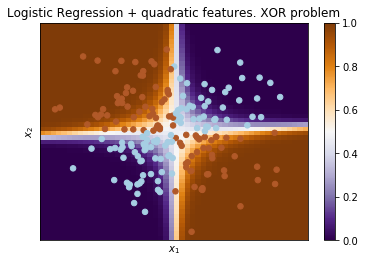

In [17]:
plot_boundary(logit_pipe, X, y,
              "Logistic Regression + quadratic features. XOR problem")

* **Таким образом, при добавлении новых нелинейных признаков с помощью линейного классификатора можно решить линейно неразделимую задачу.**

* **Другой способ решить такую задачу - сразу использовать нелинейные классификаторы. Попробуем его.**

## Задача 3: есть ли у человека болезнь сердца (задача бинарной классификации).

![Сердце](heart.jpg)

Вам необходимо предсказать, болен пациент или здоров (target) и добиться наиболее высокого качества предсказания (accuracy). Можно использовать любые методы работы с данными.

Обучение необходимо провести на данных heart.csv.

Метрика качества - accuracy.


### Описание данных

age - age in years

sex - (1 = male; 0 = female)

cpchest - pain type

trestbpsresting - blood pressure (in mm Hg on admission to the hospital)

cholserum - cholestoral in mg/dl

fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

restecg - resting electrocardiographic results

thalach - maximum heart rate achieved

exang - exercise induced angina (1 = yes; 0 = no)

oldpeak - ST depression induced by exercise relative to rest

slope - the slope of the peak exercise ST segment

ca - number of major vessels (0-3) colored by flourosopy

thal - 3 = normal; 6 = fixed defect; 7 = reversable defect

target - 1 or 0

In [19]:
import pandas as pd

df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [20]:
y = df['target']

X = df.copy()
X.drop('target',axis=1,inplace=True)

Обучим различные классификаторы и посмотрим на их качество на кросс-валидации.

Начнём с логистической регрессии.

In [21]:
model_log_reg = LogisticRegression()

cross_val_score(model_log_reg, X, y, cv=5, scoring='accuracy').mean()

0.8215300546448088

Теперь попробуем наивный байесовский классификатор.

In [22]:
from sklearn.naive_bayes import GaussianNB

model_naive_bayes = GaussianNB()

cross_val_score(model_naive_bayes, X, y, cv=5, scoring='accuracy').mean()

0.8050819672131148

Теперь - метод k ближайших соседей.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()

cross_val_score(model_knn, X, y, cv=5, scoring='accuracy').mean()

0.643879781420765

Попробуем использовать метод опорных векторов.

In [24]:
from sklearn.svm import SVC, LinearSVC

model_svc_lin = SVC(kernel='linear')

cross_val_score(model_svc_lin, X, y, cv=5, scoring='accuracy').mean()

0.8283060109289618

Попробуем использовать rbf с ядром.

In [25]:
from sklearn.svm import SVC

model_svc_rbf = SVC(kernel='rbf')

cross_val_score(model_svc_rbf, X, y, cv=5, scoring='accuracy').mean()

0.5445901639344262

### Калибровка вероятностей

Посмотрим, можно ли улучшить модель при помощи калибровки вероятностей, используя класс [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html). Для оценки качества будем использовать [Brier score](https://en.wikipedia.org/wiki/Brier_score).

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def plot_calibration_curve(est, name):
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    fig = plt.figure(figsize=(14, 7))

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name), (isotonic, name + ' + Isotonic'), (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % (name, clf_score))

    plt.ylabel("Fraction of positives")
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="lower right")
    plt.title('Calibration plots  (reliability curve)')

    plt.tight_layout()

[-1.08369296  0.54756108  1.01245383 -3.27818353  2.72779016  2.14509636
  0.23593418 -5.00750538 -3.7075908  -0.12269344  1.61294633 -1.67358653
  2.19997087 -2.80370624  3.26917017  2.33354881  3.06938682 -2.34716808
 -4.29854611 -2.92455812  0.41632947 -3.0243542  -0.5896484   0.87585595
  1.79856766  0.09823962  2.10737191  0.49071539 -4.1559724   2.04289792
 -2.80748286 -2.80491892 -4.22330626 -1.32058153  1.28723966 -2.29612485
  1.46365913  1.63251164  0.87384004  1.4251457  -0.83329057  1.28236724
  1.96734736  0.95840916  0.98685467 -4.97874128  2.62129736  2.88646994
 -0.99459094 -3.26624301 -2.39253088 -4.63254475  2.04745492  2.99740006
 -1.74169898 -5.71490382 -3.05672855  2.66832663 -3.08838297 -4.62838297
 -2.41282872  2.03560709 -2.09358321  0.36521522  1.38343339 -2.05955853
  1.03221105  1.37459722  1.25309279  2.59101028  2.29106673  1.42958226
  0.22195296  1.3976127  -1.27101387  1.95623438  0.57825845  1.89175918
 -1.54967468 -3.60817555 -0.90101999 -1.47455042  0

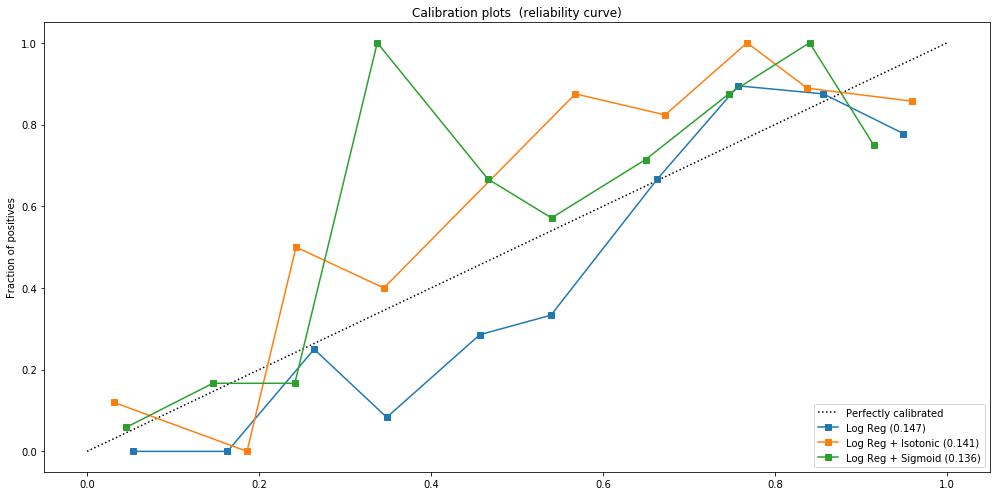

In [45]:
plot_calibration_curve(model_svc_lin, "Log Reg")

In [ ]:
#your code here